# DeepONet - Predição de Permer (K_eff)

### Objetivo do Modelo

O DeepONet é uma rede neural que **aprende a relação entre heterogeneidade microscópica e propriedades efetivas macroscópicas**.

### Problema Resolvido: Homogeneização

**Entrada (Branch):**
- Campo de permeabilidade heterogêneo $K(x,y)$ medido em **N pontos** da malha
- Representa a variação espacial da permeabilidade em escala fina (microscópica)

**Saída (Predição):**
- Propriedades efetivas escalares: $K_{xx}^{eff}$ e $K_{yy}^{eff}$
- Representam o comportamento médio/homogeneizado em escala grossa (macroscópica)
- São **2 valores únicos** que resumem a heterogeneidade do campo inteiro

### Como o DeepONet Prediz K_eff


- **Branch**: Extrai **assinatura da heterogeneidade** - "Como o campo varia?"
- **Trunk**: Codifica **efeitos posicionais** - "Onde estamos na malha?"
- **Produto Interno**: Combina ambos para prever o comportamento macroscópico efetivo

### Exemplo Prático

| Entrada | Saída Esperada |
|---------|---------|
| Campo K com alta variabilidade | K_eff elevado (mais dispersão) |
| Campo K quase uniforme | K_eff próximo ao valor médio |
| Campo K anisotrópico | K_xx_eff ≠ K_yy_eff |

In [122]:
import os
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.patches import Rectangle
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

warnings.filterwarnings("ignore")  # Suprimir avisos para clareza na saída

In [123]:
#"aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

In [159]:
PASTA_DADOS = "/home/dairsonalbert/projeto_final_FEM_Mecanica/projeto-fem-mec-continuo/dataset_deeponet/"
PASTA_PLOTS ="/home/dairsonalbert/projeto_final_FEM_Mecanica/projeto-fem-mec-continuo/results/plots"
PASTA_MODELO= "/home/dairsonalbert/projeto_final_FEM_Mecanica/projeto-fem-mec-continuo/modelo_deepONet"
# com dataset completo 10000
PASTA_DADOS = "/home/dairsonalbert/mecanica_continuo/dataset_deeponet/"
dados = np.load(f"{PASTA_DADOS}dataset_homogeneizacao.npz")
print(dados)

NpzFile '/home/dairsonalbert/mecanica_continuo/dataset_deeponet/dataset_homogeneizacao.npz' with keys: branch, target, coords, pressao_x_y


In [125]:
# -----------------------------------------------------------------------------
# Carregamento dos dados salvos do dataset para uso no modelo
# -----------------------------------------------------------------------------

# Conversão dos dados de entrada para tensores PyTorch
# 'branch' representa o campo de permeabilidade heterogêneo do meio poroso,
# que será utilizado como entrada para a DeepONet.
dados_entrada = torch.tensor(dados["branch"], dtype=torch.float32)          

# Conversão dos dados de saída para tensores PyTorch
# 'target' contém as propriedades efetivas do meio (K_eff), que são os
# valores que o modelo deve prever. Cada ponto corresponde a uma média
# homogenizada das propriedades físicas do domínio.
dados_saida = torch.tensor(dados["target"], dtype=torch.float32)             

# Conversão das coordenadas da malha para tensores PyTorch
# 'coords' fornece a posição espacial de cada nó da malha, permitindo mapear
# os campos físicos (como pressão e permeabilidade) no domínio bidimensional.
coordenadas = torch.tensor(dados['coords'], dtype=torch.float32)             

# Componentes do campo de pressão em cada ponto da malha
# pressao_x e pressao_y representam a pressão ao longo dos eixos X e Y, 
# fornecendo informações sobre o escoamento no meio contínuo.
pressao_x = torch.tensor(dados['pressao_x_y'][0], dtype=torch.float32)      
pressao_y = torch.tensor(dados['pressao_x_y'][1], dtype=torch.float32)      

# Quantidade de sensores ou nós na malha
# Determina o tamanho do conjunto de dados e é usado para iteração em loops
# ou batch processing durante o treinamento.
n_sensores = dados_entrada.shape[0]  

# Dimensão do espaço físico
# Indica que as coordenadas estão em um plano 2D (x, y).
dim_coords = 2                        


In [126]:

print(f"Entrada (Ramo K(x,y)): {dados_entrada.shape} -> (Amostras, Componentes, Sensores)")
print(f"Tronco (Coordenadas):   {coordenadas.shape}  -> (Pontos, 2)")
print(f"Saída (K_eff):          {dados_saida.shape} -> (Amostras, Componentes)")
print(f"Número de sensores:     {n_sensores}")
print(f"Dimensão das coordenadas: {dim_coords}")

print(f"************************************************************")

print(f"Verificação de valores inválidos:")
print(f"  Dados entrada - NaN: {dados_entrada.isnan().sum()}, -Inf: {dados_entrada.isneginf().sum()}")
print(f"  Dados saída - NaN: {dados_saida.isnan().sum()}, -Inf: {dados_saida.isneginf().sum()}")
print(f"  Coordenadas - NaN: {coordenadas.isnan().sum()}, -Inf: {coordenadas.isneginf().sum()}")

Entrada (Ramo K(x,y)): torch.Size([10000, 2, 800]) -> (Amostras, Componentes, Sensores)
Tronco (Coordenadas):   torch.Size([441, 2])  -> (Pontos, 2)
Saída (K_eff):          torch.Size([10000, 2]) -> (Amostras, Componentes)
Número de sensores:     10000
Dimensão das coordenadas: 2
************************************************************
Verificação de valores inválidos:
  Dados entrada - NaN: 0, -Inf: 0
  Dados saída - NaN: 0, -Inf: 0
  Coordenadas - NaN: 0, -Inf: 0


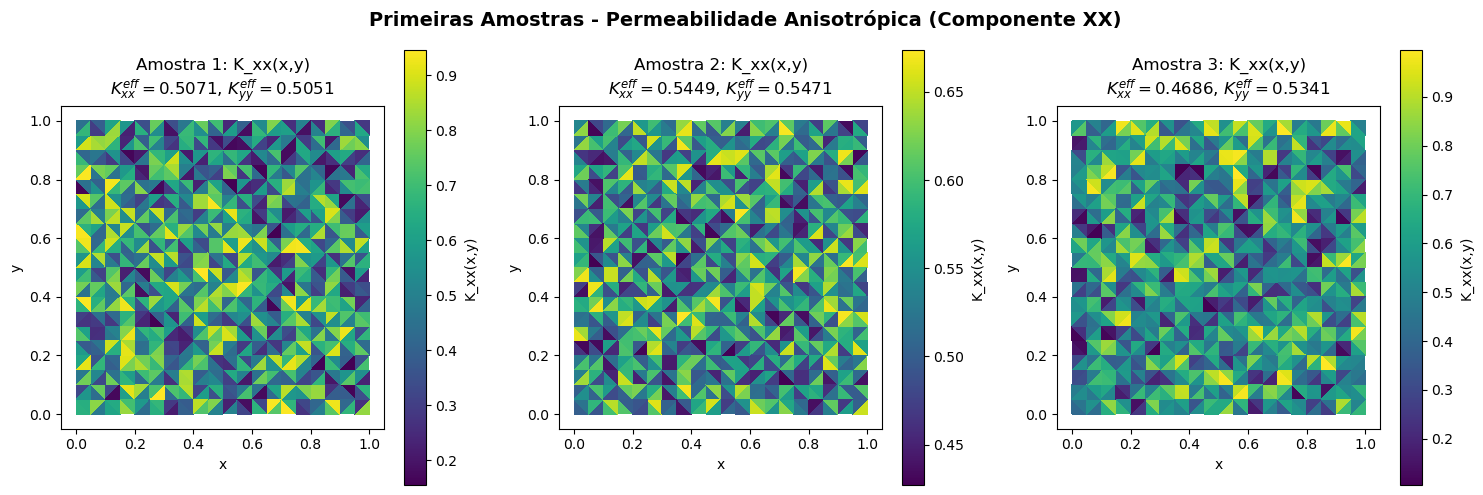


 Visualização concluída!


In [127]:

# -----------------------------------------------------------------------------
# Criação da triangulação da malha para visualização
# -----------------------------------------------------------------------------
# Usando as coordenadas dos nós para criar uma malha triangular (Firedrake/matplotlib)
# A triangulação permite a plotagem de campos escalar contínuos sobre elementos discretos.
triang = tri.Triangulation(coordenadas[:, 0], coordenadas[:, 1])

# -----------------------------------------------------------------------------
# Configuração da visualização das primeiras amostras
# -----------------------------------------------------------------------------
num_amostras_plot = min(3, len(coordenadas))  # Plotar no máximo 3 amostras
fig, axs = plt.subplots(1, num_amostras_plot, figsize=(15, 5))

# Garantir que axs seja sempre uma lista mesmo para uma única amostra
if num_amostras_plot == 1:
    axs = [axs]

# Loop sobre as amostras selecionadas
for i in range(num_amostras_plot):
    # Extrair componentes da permeabilidade para a amostra i
    K_xx_amostra = dados_entrada[i][0]        # Componente xx
    K_yy_amostra = dados_entrada[i][1]        # Componente yy
    K_xx_efetivo, K_yy_efetivo = dados_saida[i]  # Propriedades efetivas homogenizadas

    # Plotagem do campo K_xx na malha triangular
    tcf = axs[i].tripcolor(triang, K_xx_amostra, cmap='viridis', shading='flat')
    axs[i].set_aspect('equal')  # Manter proporção 1:1 para x e y
    axs[i].set_title(f"Amostra {i+1}: K_xx(x,y)\n$K_{{xx}}^{{eff}}={K_xx_efetivo:.4f}$, $K_{{yy}}^{{eff}}={K_yy_efetivo:.4f}$")
    axs[i].set_xlabel("x")
    axs[i].set_ylabel("y")
    plt.colorbar(tcf, ax=axs[i], label="K_xx(x,y)")  # Barra de cores indicando magnitude

# Título geral da figura
plt.suptitle("Primeiras Amostras - Permeabilidade Anisotrópica (Componente XX)", fontsize=14, fontweight='bold')
plt.tight_layout()  # Ajuste automático do layout
plt.show()

# Confirmação de conclusão da visualização
print(f"\n Visualização concluída!")


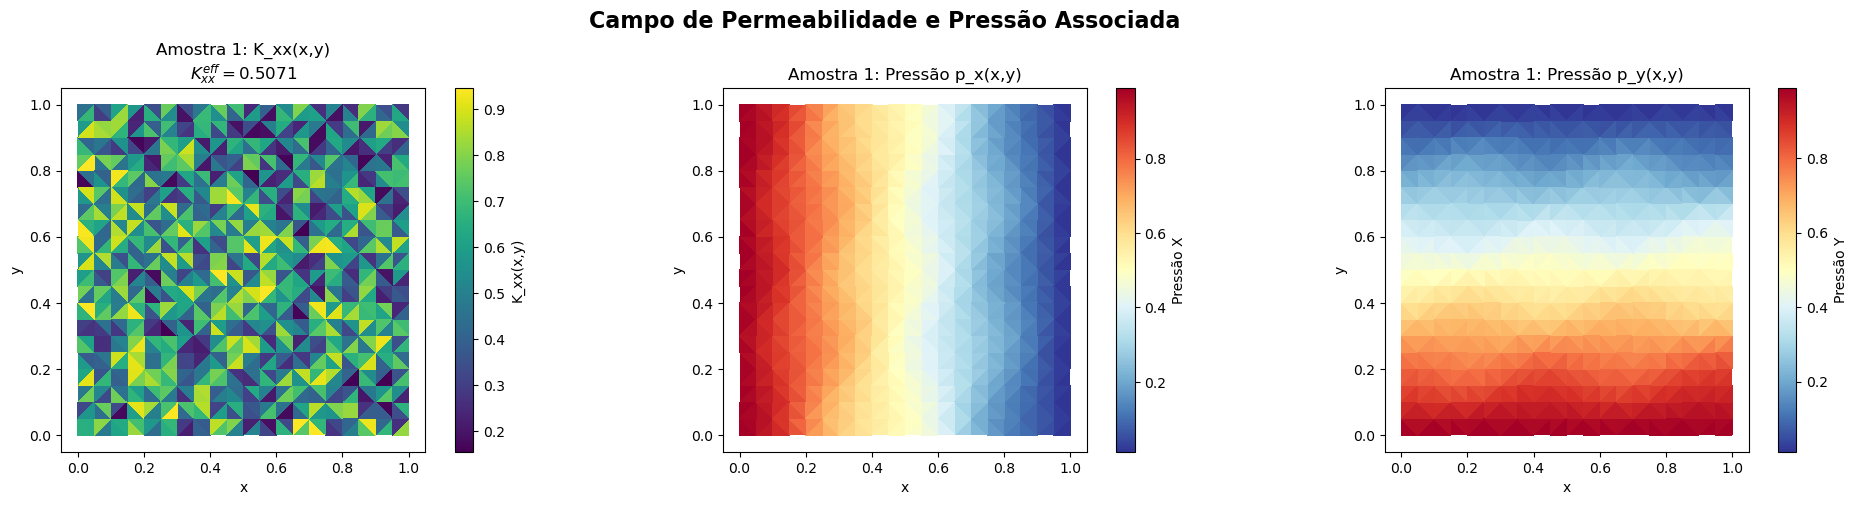


 Visualização de permeabilidade e pressão concluída!


In [128]:
# -----------------------------------------------------------------------------
# Visualização conjunta do campo de permeabilidade e das componentes de pressão
# -----------------------------------------------------------------------------

# Limitar a visualização a 1 amostra para detalhamento
num_amostras_plot = min(1, len(coordenadas))

# Criar figura com 3 colunas (K_xx, Pressão X, Pressão Y)
fig, axs = plt.subplots(num_amostras_plot, 3, figsize=(20, 5*num_amostras_plot))

# Garantir que axs seja 2D mesmo para 1 amostra
if num_amostras_plot == 1:
    axs = axs.reshape(1, -1)

# Loop sobre cada amostra selecionada
for i in range(num_amostras_plot):
    # Extrair campos de permeabilidade e propriedades efetivas
    K_xx_amostra = dados_entrada[i][0]   # Componente xx
    K_yy_amostra = dados_entrada[i][1]   # Componente yy (não plotado)
    K_xx_efetivo, K_yy_efetivo = dados_saida[i]

    # -----------------------------
    # Plotagem do campo K_xx
    # -----------------------------
    tcf1 = axs[i, 0].tripcolor(triang, K_xx_amostra, cmap='viridis', shading='flat')
    axs[i, 0].set_aspect('equal')
    axs[i, 0].set_title(f"Amostra {i+1}: K_xx(x,y)\n$K_{{xx}}^{{eff}}={K_xx_efetivo:.4f}$")
    axs[i, 0].set_xlabel("x")
    axs[i, 0].set_ylabel("y")
    plt.colorbar(tcf1, ax=axs[i, 0], label="K_xx(x,y)")

    # -----------------------------
    # Plotagem do campo de pressão X
    # -----------------------------
    tcf2 = axs[i, 1].tripcolor(triang, pressao_x[i], cmap='RdYlBu_r', shading='flat')
    axs[i, 1].set_aspect('equal')
    axs[i, 1].set_title(f"Amostra {i+1}: Pressão p_x(x,y)")
    axs[i, 1].set_xlabel("x")
    axs[i, 1].set_ylabel("y")
    plt.colorbar(tcf2, ax=axs[i, 1], label="Pressão X")

    # -----------------------------
    # Plotagem do campo de pressão Y
    # -----------------------------
    tcf3 = axs[i, 2].tripcolor(triang, pressao_y[i], cmap='RdYlBu_r', shading='flat')
    axs[i, 2].set_aspect('equal')
    axs[i, 2].set_title(f"Amostra {i+1}: Pressão p_y(x,y)")
    axs[i, 2].set_xlabel("x")
    axs[i, 2].set_ylabel("y")
    plt.colorbar(tcf3, ax=axs[i, 2], label="Pressão Y")

# Título geral da figura
plt.suptitle("Campo de Permeabilidade e Pressão Associada", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n Visualização de permeabilidade e pressão concluída!")


# Analise exploratoria dos dados

In [129]:

# plt.figure(figsize=(14, 5))

# # Histograma da Permeabilidade (Entrada)
# plt.subplot(1, 2, 1)
# sns.histplot(dados_entrada.flatten(), bins=50, kde=True, color='teal')
# plt.title('Distribuição da Permeabilidade (K)')
# plt.xlabel('Valor')
# plt.ylabel('Contagem')

# # Histograma da Propriedade Efetiva (Saída)
# plt.subplot(1, 2, 2)
# sns.histplot(dados_saida.flatten(), bins=50, kde=True, color='orange')
# plt.title('Distribuição da Propriedade Efetiva (K_eff)')
# plt.xlabel('Valor')
# plt.ylabel('Contagem')

# plt.tight_layout()
# plt.show()

# PREPARAR DADOS

In [130]:
# PREPARAR DADOS
# Importar StandardScaler do sklearn
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split


print("✓ StandardScaler importado do sklearn")

✓ StandardScaler importado do sklearn


In [131]:
# -----------------------------------------------------------------------------
# Divisão do dataset em conjuntos de Treino, Validação e Teste
# -----------------------------------------------------------------------------
# Este bloco realiza a partição do conjunto de dados em três subconjuntos:
# 1. Treino: utilizado para ajustar os pesos da rede neural (DeepONet).
# 2. Validação: usado para monitorar o desempenho durante o treinamento,
#    prevenir overfitting e ajustar hiperparâmetros.
# 3. Teste: conjunto de avaliação final, composto por dados não vistos pelo modelo,
#    permitindo estimar sua capacidade de generalização.

# Definir parâmetros iniciais
n_amostras = dados_entrada.shape[0]       # Número total de amostras disponíveis
indices_amostras = np.arange(n_amostras)  # Índices de 0 até n_amostras-1 para seleção aleatória

# -----------------------------------------------------------------------------
# Primeira divisão: separar o conjunto de teste
# -----------------------------------------------------------------------------
# Seleciona 10% do dataset como teste final, garantindo que essas amostras
# não serão usadas em nenhum estágio de treinamento ou validação.
indices_temp, indice_teste = train_test_split(
    indices_amostras, test_size=0.1, random_state=42
)

# -----------------------------------------------------------------------------
# Segunda divisão: separar treino e validação
# -----------------------------------------------------------------------------
# O conjunto restante (90% das amostras) é dividido em:
# - Treino: 75% do restante (aproximadamente 67.5% do total)
# - Validação: 25% do restante (aproximadamente 22.5% do total)
# Este procedimento garante proporções equilibradas e reprodutíveis
# usando o parâmetro random_state.
indice_treino, indice_validacao = train_test_split(
    indices_temp, test_size=0.25, random_state=42
)

# -----------------------------------------------------------------------------
# Criação dos conjuntos finais de dados
# -----------------------------------------------------------------------------
# Conversão dos índices selecionados para arrays de dados correspondentes
# mantendo a consistência entre entrada (campo K(x,y)) e saída (K_eff)
dados_ramo_treino = dados_entrada[indice_treino]
dados_alvo_treino = dados_saida[indice_treino]

dados_ramo_validacao = dados_entrada[indice_validacao]
dados_alvo_validacao = dados_saida[indice_validacao]

dados_ramo_teste = dados_entrada[indice_teste]
dados_alvo_teste = dados_saida[indice_teste]

# -----------------------------------------------------------------------------
# Impressão de resumo da divisão
# -----------------------------------------------------------------------------
# Exibe as proporções reais de cada subconjunto em relação ao total de amostras,
# permitindo uma rápida verificação da partição do dataset
print("=" * 70)
print("DIVISÃO TREINO / VALIDAÇÃO / TESTE (67.5% / 22.5% / 10%)")
print("=" * 70)
print(f"Treino:      {dados_ramo_treino.shape[0]:>3} amostras ({dados_ramo_treino.shape[0]/n_amostras*100:.1f}%)")
print(f"Validação:   {dados_ramo_validacao.shape[0]:>3} amostras ({dados_ramo_validacao.shape[0]/n_amostras*100:.1f}%)")
print(f"Teste:       {dados_ramo_teste.shape[0]:>3} amostras ({dados_ramo_teste.shape[0]/n_amostras*100:.1f}%)")
print(f"Total:       {n_amostras:>3} amostras")
print("=" * 70)


DIVISÃO TREINO / VALIDAÇÃO / TESTE (67.5% / 22.5% / 10%)
Treino:      6750 amostras (67.5%)
Validação:   2250 amostras (22.5%)
Teste:       1000 amostras (10.0%)
Total:       10000 amostras


In [132]:
# -----------------------------------------------------------------------------
# Criação de escaladores para normalização dos dados
# -----------------------------------------------------------------------------
# Normalização é uma etapa crucial em aprendizado de máquina, especialmente para
# redes neurais, pois garante que todas as variáveis tenham média zero e desvio
# padrão unitário, evitando que variáveis com magnitudes maiores dominem o aprendizado.

# Escalador para os dados de entrada (campo K(x,y) - "Branch" da DeepONet)
escalador_ramo = StandardScaler()

# Escalador para os dados de saída (propriedades efetivas K_eff - "alvo")
escalador_alvo = StandardScaler()

# Escalador para as coordenadas da malha (entrada do "Trunk" da DeepONet)
escalador_tronco = StandardScaler()


In [133]:
# -----------------------------------------------------------------------------
# Normalização dos dados usando StandardScaler
# -----------------------------------------------------------------------------
# A normalização é aplicada **apenas ao conjunto de treino** durante o ajuste (fit)
# para evitar vazamento de informação do conjunto de validação ou teste.
# Depois, os mesmos escaladores são usados para transformar todos os conjuntos.



# -----------------------------------------------------------------------------
# Preparação dos dados do ramo (entrada da DeepONet)
# -----------------------------------------------------------------------------
# Reshape necessário: de (n_amostras, 2, n_sensores) para (n_amostras, 2*n_sensores)
# porque o StandardScaler espera um array 2D (amostras x features)
dados_ramo_treino_2d = dados_ramo_treino.reshape(dados_ramo_treino.shape[0], -1).numpy()
dados_ramo_validacao_2d = dados_ramo_validacao.reshape(dados_ramo_validacao.shape[0], -1).numpy()
dados_ramo_teste_2d = dados_ramo_teste.reshape(dados_ramo_teste.shape[0], -1).numpy()

# -----------------------------------------------------------------------------
# Ajuste dos escaladores (fit) apenas nos dados de TREINO
# -----------------------------------------------------------------------------
# - escalador_ramo: normaliza o campo de permeabilidade heterogêneo
# - escalador_alvo: normaliza as propriedades efetivas K_eff
# - escalador_tronco: normaliza as coordenadas da malha (entrada do tronco)
escalador_ramo.fit(dados_ramo_treino_2d)
escalador_alvo.fit(dados_alvo_treino.numpy())
escalador_tronco.fit(coordenadas.numpy())

# -----------------------------------------------------------------------------
# Aplicação da transformação (transform) nos conjuntos TREINO, VALIDAÇÃO e TESTE
# -----------------------------------------------------------------------------
# TREINO
dados_ramo_treino_norm_2d = escalador_ramo.transform(dados_ramo_treino_2d)
dados_ramo_treino_norm = torch.tensor(dados_ramo_treino_norm_2d, dtype=torch.float32).reshape(dados_ramo_treino.shape)
dados_alvo_treino_norm = torch.tensor(escalador_alvo.transform(dados_alvo_treino.numpy()), dtype=torch.float32)

# VALIDAÇÃO
# Usa os MESMOS escaladores ajustados no treino para evitar vazamento de dados
dados_ramo_validacao_norm_2d = escalador_ramo.transform(dados_ramo_validacao_2d)
dados_ramo_validacao_norm = torch.tensor(dados_ramo_validacao_norm_2d, dtype=torch.float32).reshape(dados_ramo_validacao.shape)
dados_alvo_validacao_norm = torch.tensor(escalador_alvo.transform(dados_alvo_validacao.numpy()), dtype=torch.float32)

# TESTE
# Também utiliza os escaladores ajustados no treino
dados_ramo_teste_norm_2d = escalador_ramo.transform(dados_ramo_teste_2d)
dados_ramo_teste_norm = torch.tensor(dados_ramo_teste_norm_2d, dtype=torch.float32).reshape(dados_ramo_teste.shape)
dados_alvo_teste_norm = torch.tensor(escalador_alvo.transform(dados_alvo_teste.numpy()), dtype=torch.float32)

# -----------------------------------------------------------------------------
# Normalização do tronco (coordenadas da malha)
# -----------------------------------------------------------------------------
# Normalização única para todas as amostras e conjuntos, pois as coordenadas são
# fixas e não dependem de treino, validação ou teste
coordenadas_norm = torch.tensor(escalador_tronco.transform(coordenadas.numpy()), dtype=torch.float32)


In [134]:

# Verificar normalização
print("=" * 80)
print("VERIFICAÇÃO DA NORMALIZAÇÃO")
print("=" * 80)

print(f"\n--- TREINO (67.5%) ---")
print(f"Ramo - Média: {dados_ramo_treino_norm.mean():>9.6f}, Desv.Pad: {dados_ramo_treino_norm.std():.6f}")
print(f"Alvo - Média: {dados_alvo_treino_norm.mean():>9.6f}, Desv.Pad: {dados_alvo_treino_norm.std():.6f}")

print(f"\n--- VALIDAÇÃO (22.5%) ---")
print(f"Ramo - Média: {dados_ramo_validacao_norm.mean():>9.6f}, Desv.Pad: {dados_ramo_validacao_norm.std():.6f}")
print(f"Alvo - Média: {dados_alvo_validacao_norm.mean():>9.6f}, Desv.Pad: {dados_alvo_validacao_norm.std():.6f}")

print(f"\n--- TESTE (10%) ---")
print(f"Ramo - Média: {dados_ramo_teste_norm.mean():>9.6f}, Desv.Pad: {dados_ramo_teste_norm.std():.6f}")
print(f"Alvo - Média: {dados_alvo_teste_norm.mean():>9.6f}, Desv.Pad: {dados_alvo_teste_norm.std():.6f}")

print(f"\n--- TRONCO (Coordenadas - Compartilhado) ---")
print(f"Média: {coordenadas_norm.mean():>9.6f}, Desv.Pad: {coordenadas_norm.std():.6f}")


VERIFICAÇÃO DA NORMALIZAÇÃO

--- TREINO (67.5%) ---
Ramo - Média:  0.000000, Desv.Pad: 1.000000
Alvo - Média: -0.000000, Desv.Pad: 1.000037

--- VALIDAÇÃO (22.5%) ---
Ramo - Média:  0.000221, Desv.Pad: 0.993327
Alvo - Média:  0.016122, Desv.Pad: 1.023453

--- TESTE (10%) ---
Ramo - Média: -0.000924, Desv.Pad: 0.987263
Alvo - Média:  0.028182, Desv.Pad: 0.995867

--- TRONCO (Coordenadas - Compartilhado) ---
Média:  0.000000, Desv.Pad: 1.000567


In [135]:
# -----------------------------------------------------------------------------
# Preparar dados finais para o modelo DeepONet
# -----------------------------------------------------------------------------
# Nesta etapa, os dados normalizados são organizados para entrada na DeepONet,
# separando claramente:
# 1. Branch (ramo): entrada representando o campo heterogêneo de permeabilidade K(x,y)
# 2. Target (alvo): saída que o modelo deve aprender a predizer, K_eff
# 3. Trunk (tronco): entrada fixa de coordenadas espaciais da malha

print("=" * 80)
print("PREPARAÇÃO FINAL DOS DADOS PARA O MODELO")
print("=" * 80)

# -----------------------------------------------------------------------------
# Dados de TREINO
# -----------------------------------------------------------------------------
branch_train = dados_ramo_treino_norm      # Campo de permeabilidade normalizado
target_train = dados_alvo_treino_norm      # Propriedades efetivas K_eff normalizadas

# -----------------------------------------------------------------------------
# Dados de VALIDAÇÃO
# -----------------------------------------------------------------------------
branch_val = dados_ramo_validacao_norm     # Campo de permeabilidade normalizado
target_val = dados_alvo_validacao_norm     # Propriedades efetivas K_eff normalizadas

# -----------------------------------------------------------------------------
# Dados de TESTE
# -----------------------------------------------------------------------------
branch_test = dados_ramo_teste_norm        # Campo de permeabilidade normalizado
target_test = dados_alvo_teste_norm        # Propriedades efetivas K_eff normalizadas

# -----------------------------------------------------------------------------
# Coordenadas da malha (tronco), compartilhado para todos os conjuntos
# -----------------------------------------------------------------------------
trunk_data = coordenadas_norm              # Coordenadas normalizadas, entrada do tronco da DeepONet

# -----------------------------------------------------------------------------
# Impressão resumida das dimensões e do tipo de dado
# -----------------------------------------------------------------------------
print(f"\n✓ TREINO (67.5%):")
print(f"  • branch_train: {branch_train.shape}  (entrada)")
print(f"  • target_train: {target_train.shape}   (saída)")

print(f"\n✓ VALIDAÇÃO (22.5 %):")
print(f"  • branch_val:   {branch_val.shape}  (entrada)")
print(f"  • target_val:   {target_val.shape}   (saída)")
    
print(f"\n✓ TESTE (20%):")
print(f"  • branch_test:  {branch_test.shape}  (entrada)")
print(f"  • target_test:  {target_test.shape}   (saída)")

print(f"\n✓ COMPARTILHADO:")
print(f"  • trunk_data:   {trunk_data.shape}  (coordenadas da malha)")


PREPARAÇÃO FINAL DOS DADOS PARA O MODELO

✓ TREINO (67.5%):
  • branch_train: torch.Size([6750, 2, 800])  (entrada)
  • target_train: torch.Size([6750, 2])   (saída)

✓ VALIDAÇÃO (22.5 %):
  • branch_val:   torch.Size([2250, 2, 800])  (entrada)
  • target_val:   torch.Size([2250, 2])   (saída)

✓ TESTE (20%):
  • branch_test:  torch.Size([1000, 2, 800])  (entrada)
  • target_test:  torch.Size([1000, 2])   (saída)

✓ COMPARTILHADO:
  • trunk_data:   torch.Size([441, 2])  (coordenadas da malha)


# DeepOnet

In [136]:
# -----------------------------------------------------------------------------
# Arquitetura DeepONet para modelagem de permeabilidade efetiva em meios heterogêneos
# -----------------------------------------------------------------------------
# A DeepONet é um modelo de operador neural capaz de mapear funções (ou campos)
# de entrada para funções de saída. Neste caso:
# - Entrada (Branch): campo de permeabilidade heterogêneo K(x,y)
# - Entrada (Trunk): coordenadas espaciais (x, y) dos pontos da malha
# - Saída: propriedades efetivas (K_xx_eff e K_yy_eff)
# A saída é obtida via produto interno entre as representações latentes do branch e do trunk.

# Dimensões de entrada do modelo
branch_input_dim = branch_train.shape[1] * branch_train.shape[2]  # 2 componentes * 5000 sensores
trunk_input_dim = trunk_data.shape[1]                              # 2 dimensões espaciais (x, y)
hidden_dim = 128                                                   # dimensão latente compartilhada

# -----------------------------------------------------------------------------
# Rede BranchNet
# -----------------------------------------------------------------------------
class BranchNet(nn.Module):
    """
    Rede totalmente conectada responsável por processar a entrada do ramo.
    
    Objetivo científico:
    - Capturar padrões e dependências não-lineares do campo de permeabilidade K(x,y)
    - Produzir uma representação latente de dimensão 'hidden_dim'
    - Permitir generalização a novas amostras de entrada
    """
    def __init__(self, input_dim=1, hidden_dims=[128, 128, 128], output_dim=128):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))  # Camada totalmente conectada
            layers.append(nn.ReLU())                        # Não linearidade para capturar complexidade
        layers.append(nn.Linear(dims[-1], output_dim))     # Camada de saída latente
        self.net = nn.Sequential(*layers)

    def forward(self, branch_flat):
        # branch_flat: tensor 2D (batch_size, input_dim)
        # Saída: representação latente do branch (batch_size, hidden_dim)
        return self.net(branch_flat)

# -----------------------------------------------------------------------------
# Rede TrunkNet
# -----------------------------------------------------------------------------
class TrunkNet(nn.Module):
    """
    Rede totalmente conectada responsável por processar as coordenadas do tronco.
    
    Objetivo científico:
    - Extrair uma representação latente das coordenadas espaciais
    - Permitir que o modelo avalie o campo de saída em qualquer ponto da malha
    """
    def __init__(self, input_dim=2, hidden_dims=[128, 128, 128], output_dim=128):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(dims[-1], output_dim))  # Saída latente para coordenadas
        self.net = nn.Sequential(*layers)

    def forward(self, coords):
        # coords: (P, 2) ou (batch, P, 2)
        # Garante dimensão de batch para compatibilidade com BranchNet
        if coords.dim() == 2:
            coords = coords.unsqueeze(0)  # (1, P, 2)
        # Saída: representação latente do tronco (batch_size, P, hidden_dim)
        return self.net(coords)

# -----------------------------------------------------------------------------
# Rede DeepONet completa
# -----------------------------------------------------------------------------
class DeepONet(nn.Module):
    """
    Combina BranchNet e TrunkNet para predizer propriedades efetivas K_eff
    a partir de um campo de permeabilidade e coordenadas espaciais.

    Operações científicas:
    1. Achata o ramo para vetor 2D, permitindo camadas lineares totalmente conectadas
    2. Calcula representação latente do ramo (b_out) e do tronco (t_out)
    3. Realiza produto ponto a ponto b_out * t_out (produto interno no espaço latente)
    4. Aplica camada linear (head) para mapear representação latente para saída física
    5. Faz média sobre pontos da malha e adiciona bias treinável para ajuste de escala
    """
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_dim=128):
        super().__init__()
        self.branch_net = BranchNet(input_dim=branch_input_dim, output_dim=hidden_dim)
        self.trunk_net = TrunkNet(input_dim=trunk_input_dim, output_dim=hidden_dim)
        self.head = nn.Linear(hidden_dim, 2)  # Prediz K_xx_eff e K_yy_eff
        self.bias = nn.Parameter(torch.zeros(1))  # Ajuste médio das predições

    def forward(self, branch, coords):
        """
        branch: tensor (batch_size, 2, n_sensores) -> entrada de permeabilidade
        coords: tensor (P, 2) ou (batch_size, P, 2) -> coordenadas da malha
        """
        batch_size = branch.shape[0]
        
        # Achata a entrada do ramo: (batch_size, branch_input_dim)
        branch_flat = branch.view(batch_size, -1)
        b_out = self.branch_net(branch_flat)  # Representação latente do ramo

        # Representação latente do tronco
        t_out = self.trunk_net(coords)  # (1, P, hidden_dim) ou (batch, P, hidden_dim)
        if t_out.shape[0] == 1:
            # Expande para todo o batch se tronco compartilhado
            t_out = t_out.expand(batch_size, -1, -1)

        # Produto ponto a ponto entre ramo e tronco (captura dependência funcional)
        prod = b_out.unsqueeze(1) * t_out  # (batch, P, hidden_dim)

        # Mapeamento linear para predição de K_eff em cada ponto da malha
        pointwise = self.head(prod)  # (batch, P, 2)
        keff_pred = pointwise.mean(dim=1) + self.bias  # Média sobre pontos + bias

        return keff_pred

# -----------------------------------------------------------------------------
# Instanciação do modelo
# -----------------------------------------------------------------------------
model = DeepONet(branch_input_dim=branch_input_dim, trunk_input_dim=trunk_input_dim, hidden_dim=hidden_dim)
print(model)
print(f"branch_input_dim: {branch_input_dim}, trunk_input_dim: {trunk_input_dim}, hidden_dim: {hidden_dim}")


DeepONet(
  (branch_net): BranchNet(
    (net): Sequential(
      (0): Linear(in_features=1600, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
      (6): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (trunk_net): TrunkNet(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
      (6): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (head): Linear(in_features=128, out_features=2, bias=True)
)
branch_input_dim: 1600, trunk_input_dim: 2, hidden_dim: 128


In [170]:
# -----------------------------------------------------------------------------
# Treino, Validação e Teste do modelo DeepONet
# -----------------------------------------------------------------------------
# Este bloco realiza a otimização da DeepONet para mapear campos de permeabilidade
# (branch) para propriedades efetivas (target) usando coordenadas da malha (trunk).
# Estratégia científica:
# - Minimizar o erro quadrático médio (MSE) entre predições e valores reais
# - Manter conjunto de validação separado para monitorar generalização
# - Salvar o modelo com melhor desempenho de validação para evitar overfitting
# -----------------------------------------------------------------------------

from torch.utils.data import TensorDataset, DataLoader
import copy

# ----------------------------- Configurações -----------------------------
batch_size = 100          # Número de amostras processadas por iteração
lr = 1e-3                 # Taxa de aprendizado do otimizador Adam
peso_decay = 5e-4         # Regularização L2 para evitar overfitting
num_epochs = 10         # Número máximo de épocas de treino

# Dispositivo de execução (GPU se disponível)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# ----------------------------- Preparação dos dados -----------------------------
# Transferir dados para o dispositivo escolhido (CPU/GPU)
branch_train_d = branch_train.to(device)
target_train_d = target_train.to(device)
branch_val_d = branch_val.to(device)
target_val_d = target_val.to(device)
branch_test_d = branch_test.to(device)
target_test_d = target_test.to(device)
trunk_d = trunk_data.to(device)  # Trunk compartilhado para todos os batches

# Criar DataLoaders para batching eficiente e embaralhamento das amostras de treino
train_loader = DataLoader(TensorDataset(branch_train_d, target_train_d),
                          batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(branch_val_d, target_val_d),
                        batch_size=batch_size, shuffle=False)

# ----------------------------- Inicialização do modelo e otimizador -----------------------------
model = DeepONet(branch_input_dim=branch_input_dim,
                 trunk_input_dim=trunk_input_dim,
                 hidden_dim=hidden_dim).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=peso_decay)
criterion = nn.MSELoss()  # Função de custo: erro quadrático médio (MSE)

# Variáveis para monitoramento do melhor modelo
melhor_val = float("inf")  # Inicializa com valor alto
melhor_estado = None        # Armazena os pesos do modelo com melhor validação
historico_treino = []       # Histórico do erro de treino por época
historico_val = []          # Histórico do erro de validação por época

# ----------------------------- Laço de Treino -----------------------------
for epoch in range(1, num_epochs + 1):
    # ---------- Treino ----------
    model.train()          # Ativa modo treino (dropout, batchnorm se houver)
    loss_train = 0.0
    for batch_branch, batch_target in train_loader:
        optimizer.zero_grad()               # Limpar gradientes acumulados
        pred = model(batch_branch, trunk_d) # Predição usando coordenadas compartilhadas
        loss = criterion(pred, batch_target)
        loss.backward()                     # Backpropagation do gradiente
        optimizer.step()                    # Atualização dos pesos
        loss_train += loss.item()
    loss_train /= len(train_loader)        # Média do erro sobre todos os batches

    # ---------- Validação ----------
    model.eval()           # Modo avaliação (desativa dropout/batchnorm)
    loss_val = 0.0
    with torch.no_grad():  # Não calcula gradientes durante validação
        for batch_branch, batch_target in val_loader:
            pred = model(batch_branch, trunk_d)
            loss = criterion(pred, batch_target)
            loss_val += loss.item()
    loss_val /= len(val_loader)

    # Armazenar histórico de perdas
    historico_treino.append(loss_train)
    historico_val.append(loss_val)

    # ---------- Salvar melhor modelo ----------
    if loss_val < melhor_val:
        melhor_val = loss_val
        melhor_estado = copy.deepcopy(model.state_dict())  # Salva cópia dos pesos
    
    # salvar o modelo nos arquivos
    torch.save(model.state_dict(), f"{PASTA_MODELO}/modelo_deeponet_permeabilidade.pth")


    # ---------- Impressão de progresso ----------
    if epoch % 5 == 0 or epoch == 1 or epoch == num_epochs:
        print(f"Época {epoch:03d} | Treino: {loss_train:.4f} | Val: {loss_val:.4f}")

# ---------- Restaurar melhor modelo ----------
if melhor_estado is not None:
    model.load_state_dict(melhor_estado)
    print(f"\nModelo carregado com melhor validação: MSE = {melhor_val:.4f}")
else:
    print("\nAviso: nenhum estado salvo; verifique o laço de treino.")



Usando dispositivo: cpu
Época 001 | Treino: 0.4483 | Val: 0.1997
Época 005 | Treino: 0.0528 | Val: 0.0592
Época 010 | Treino: 0.0321 | Val: 0.0406

Modelo carregado com melhor validação: MSE = 0.0406


# Começa os Plotes  para análise

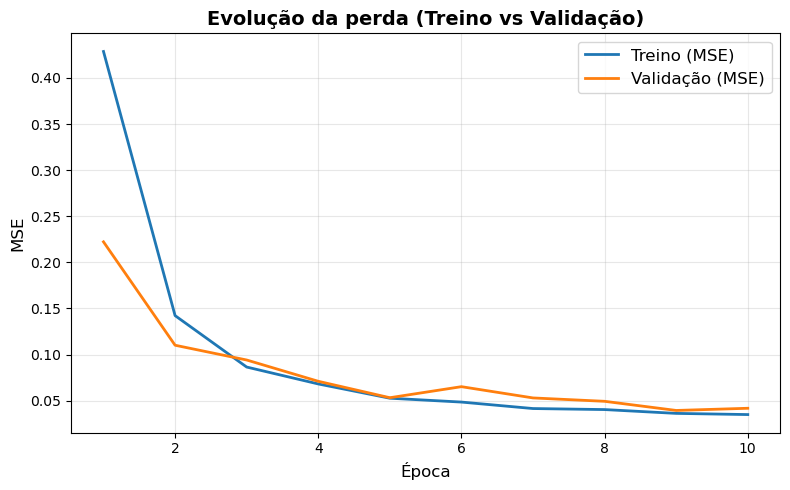

Melhor MSE de validação: 0.0394


In [138]:
# -----------------------------------------------------------------------------
# Visualização da evolução do erro quadrático médio (MSE) durante o treino
# -----------------------------------------------------------------------------
# Este bloco cria um gráfico mostrando a convergência do modelo DeepONet,
# permitindo avaliar a evolução da perda nos conjuntos de treino e validação.
# A análise visual auxilia na identificação de:
# - Sobreajuste (validação aumenta enquanto treino continua caindo)
# - Subajuste (erro alto em ambos conjuntos)
# - Estabilidade do processo de otimização
# -----------------------------------------------------------------------------

import matplotlib.pyplot as plt
import os

# Eixo X: número de épocas
epocas = list(range(1, len(historico_treino) + 1))

# Criar figura e plotar histórico de MSE
plt.figure(figsize=(8, 5))
plt.plot(epocas, historico_treino, label="Treino (MSE)", linewidth=2)
plt.plot(epocas, historico_val, label="Validação (MSE)", linewidth=2)

# Configurações visuais para facilitar interpretação
plt.xlabel("Época", fontsize=12)
plt.ylabel("MSE", fontsize=12)
plt.title("Evolução da perda (Treino vs Validação)", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)  # Grid discreto para leitura clara
plt.legend(fontsize=12)

# Ajuste de layout para evitar cortes
plt.tight_layout()

# -----------------------------------------------------------------------------
# Salvamento da figura
# -----------------------------------------------------------------------------
# Cria pasta caso não exista e salva gráfico em alta resolução
if not os.path.exists(PASTA_PLOTS):
    os.makedirs(PASTA_PLOTS)
    print(f"Pasta '{PASTA_PLOTS}' criada com sucesso.")

nome_figura = os.path.join(PASTA_PLOTS, "evolucao_mse_treino_validacao.png")
plt.savefig(
    nome_figura,
    dpi=300,           # Alta resolução adequada para publicações
    bbox_inches="tight" # Ajusta margens para não cortar legendas
)

# Exibe o gráfico na tela
plt.show()

# -----------------------------------------------------------------------------
# Impressão do melhor valor de MSE em validação
# -----------------------------------------------------------------------------
# Permite rápida referência do desempenho ótimo alcançado durante o treino
print(f"Melhor MSE de validação: {min(historico_val):.4f}")


In [139]:
# -----------------------------------------------------------------------------
# Avaliação do modelo DeepONet no conjunto de teste
# -----------------------------------------------------------------------------
# Objetivo: quantificar o desempenho do modelo em dados não vistos utilizando 
# métricas clássicas de regressão: MSE (Mean Squared Error) e MAE (Mean Absolute Error).

model.eval()  # Coloca o modelo em modo avaliação
with torch.no_grad():  # Desativa o cálculo de gradientes
    # Predição no conjunto de teste
    pred_test = model(branch_test_d, trunk_d)
    
    # Cálculo das métricas por componente
    mse_test = torch.mean((pred_test - target_test_d) ** 2, dim=0)
    mae_test = torch.mean(torch.abs(pred_test - target_test_d), dim=0)

# Impressão dos resultados
print("Avaliação em TESTE (dados normalizados):")
print(f"  MSE K_xx_eff: {mse_test[0].item():.4f} | MSE K_yy_eff: {mse_test[1].item():.4f}")
print(f"  MAE K_xx_eff: {mae_test[0].item():.4f} | MAE K_yy_eff: {mae_test[1].item():.4f}")


Avaliação em TESTE (dados normalizados):
  MSE K_xx_eff: 0.0349 | MSE K_yy_eff: 0.0308
  MAE K_xx_eff: 0.1345 | MAE K_yy_eff: 0.1323


mse_test

In [140]:
# -----------------------------------------------------------------------------
# Avaliação do modelo DeepONet no espaço ORIGINAL (desnormalizado)
# -----------------------------------------------------------------------------
# Objetivo: medir o desempenho do modelo nas unidades físicas originais, 
# permitindo interpretação direta das propriedades efetivas K_eff.
# Métricas calculadas: MSE, MAE e coeficiente de determinação R².
# -----------------------------------------------------------------------------

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Verificações de disponibilidade das variáveis
assert 'pred_test' in globals(), "pred_test não encontrado. Execute a avaliação em teste primeiro."
assert 'target_test_d' in globals(), "target_test_d não encontrado."
assert 'escalador_alvo' in globals(), "escalador_alvo não encontrado. Execute a normalização primeiro."

# Converter tensores para NumPy
pred_test_np = pred_test.detach().cpu().numpy()
target_test_np = target_test_d.detach().cpu().numpy()

# Desnormalizar para o espaço físico original
pred_test_orig = escalador_alvo.inverse_transform(pred_test_np)
target_test_orig = escalador_alvo.inverse_transform(target_test_np)

# Cálculo de métricas por componente
mse_xx = mean_squared_error(target_test_orig[:, 0], pred_test_orig[:, 0])
mse_yy = mean_squared_error(target_test_orig[:, 1], pred_test_orig[:, 1])
mae_xx = mean_absolute_error(target_test_orig[:, 0], pred_test_orig[:, 0])
mae_yy = mean_absolute_error(target_test_orig[:, 1], pred_test_orig[:, 1])
r2_xx  = r2_score(target_test_orig[:, 0], pred_test_orig[:, 0])
r2_yy  = r2_score(target_test_orig[:, 1], pred_test_orig[:, 1])

# Impressão dos resultados
print("Resultados em TESTE (espaço ORIGINAL):")
print(f"  MSE K_xx_eff: {mse_xx:.6f} | MSE K_yy_eff: {mse_yy:.6f}")
print(f"  MAE K_xx_eff: {mae_xx:.6f} | MAE K_yy_eff: {mae_yy:.6f}")
print(f"  R²  K_xx_eff: {r2_xx:.4f} | R²  K_yy_eff: {r2_yy:.4f}")


Resultados em TESTE (espaço ORIGINAL):
  MSE K_xx_eff: 0.000020 | MSE K_yy_eff: 0.000015
  MAE K_xx_eff: 0.003211 | MAE K_yy_eff: 0.002931
  R²  K_xx_eff: 0.9645 | R²  K_yy_eff: 0.9691


In [141]:

# -----------------------------------------------------------------------------
# Baseline de referência
# -----------------------------------------------------------------------------
# O baseline é uma predição simples usada como referência mínima:
# consiste em sempre prever a média do conjunto de treino para cada componente.
# Serve para comparar o desempenho do modelo com uma estratégia ingênua,
# garantindo que a rede aprendeu padrões significativos em vez de simplesmente 
# prever valores médios.
train_mean_orig = escalador_alvo.inverse_transform(target_train.detach().cpu().numpy()).mean(axis=0)
pred_baseline = np.tile(train_mean_orig, (target_test_orig.shape[0], 1))

mse_xx_bl = mean_squared_error(target_test_orig[:, 0], pred_baseline[:, 0])
mse_yy_bl = mean_squared_error(target_test_orig[:, 1], pred_baseline[:, 1])
r2_xx_bl  = r2_score(target_test_orig[:, 0], pred_baseline[:, 0])
r2_yy_bl  = r2_score(target_test_orig[:, 1], pred_baseline[:, 0])

print("\nBaseline (média do treino):")
print(f"  MSE K_xx_eff: {mse_xx_bl:.6f} | MSE K_yy_eff: {mse_yy_bl:.6f}")
print(f"  R²  K_xx_eff: {r2_xx_bl:.4f} | R²  K_yy_eff: {r2_yy_bl:.4f}")



Baseline (média do treino):
  MSE K_xx_eff: 0.000561 | MSE K_yy_eff: 0.000491
  R²  K_xx_eff: -0.0009 | R²  K_yy_eff: -0.0136


✓ Gráfico de resíduos salvo em: /home/dairsonalbert/projeto_final_FEM_Mecanica/projeto-fem-mec-continuo/results/plots/histograma_residuos_deeponet.png


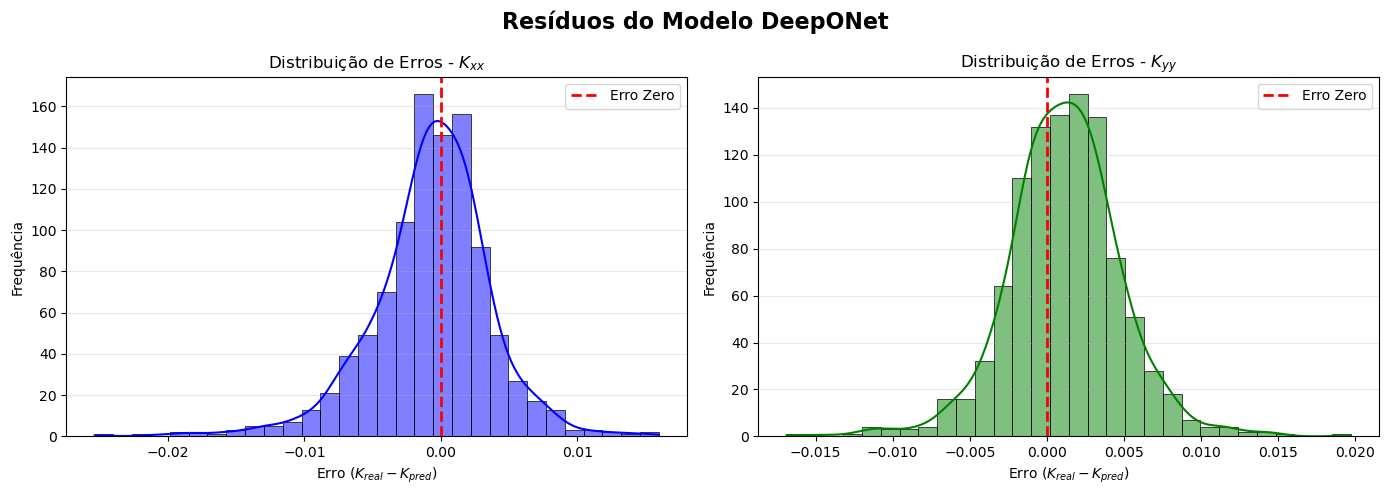

In [142]:
# -----------------------------------------------------------------------------
# Análise de Resíduos do Modelo DeepONet
# -----------------------------------------------------------------------------
# Objetivo: avaliar a diferença entre os valores reais e preditos pelo modelo
# para cada componente da permeabilidade efetiva (K_xx e K_yy). 
# Esta análise permite verificar viés, dispersão e comportamento estatístico 
# dos erros do modelo.
# -----------------------------------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# Estilo limpo e padrão
plt.style.use('default')

# Cálculo dos resíduos: erro = valor real - valor predito
residuos_xx = target_test_orig[:, 0] - pred_test_orig[:, 0]
residuos_yy = target_test_orig[:, 1] - pred_test_orig[:, 1]

# Criar figura com dois subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Histograma K_xx ---
sns.histplot(
    residuos_xx, kde=True, ax=axes[0],
    color='blue', bins=30, edgecolor='black', linewidth=0.5
)
axes[0].axvline(0, color='r', linestyle='--', linewidth=2, label='Erro Zero')
axes[0].set_title("Distribuição de Erros - $K_{xx}$")
axes[0].set_xlabel("Erro ($K_{real} - K_{pred}$)")
axes[0].set_ylabel("Frequência")
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# --- Histograma K_yy ---
sns.histplot(
    residuos_yy, kde=True, ax=axes[1],
    color='green', bins=30, edgecolor='black', linewidth=0.5
)
axes[1].axvline(0, color='r', linestyle='--', linewidth=2, label='Erro Zero')
axes[1].set_title("Distribuição de Erros - $K_{yy}$")
axes[1].set_xlabel("Erro ($K_{real} - K_{pred}$)")
axes[1].set_ylabel("Frequência")
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.suptitle("Resíduos do Modelo DeepONet", fontsize=16, fontweight='bold')
plt.tight_layout()

# -----------------------------------------------------------------------------
# Salvar figura
# -----------------------------------------------------------------------------
if 'PASTA_PLOTS' not in globals():
    PASTA_PLOTS = "."

caminho_arquivo = os.path.join(PASTA_PLOTS, "histograma_residuos_deeponet.png")

plt.savefig(
    caminho_arquivo,
    dpi=300,             # Alta resolução para publicação
    bbox_inches='tight'  # Remove margens brancas
)

print(f"✓ Gráfico de resíduos salvo em: {caminho_arquivo}")

plt.show()


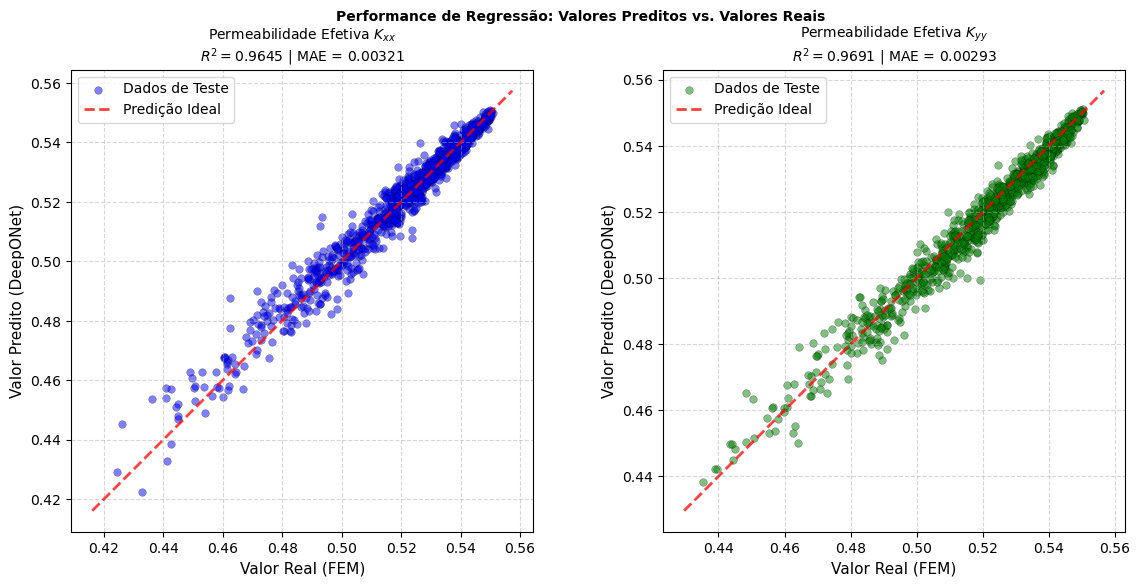

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [143]:
import matplotlib.pyplot as plt
import numpy as np

# Configuração de estilo para parecer artigo científico
plt.style.use('default') 
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Gráfico K_xx ---
ax = axes[0]
ax.scatter(target_test_orig[:, 0], pred_test_orig[:, 0], 
           c='blue', alpha=0.5, s=30, label='Dados de Teste', edgecolors='k', linewidth=0.3)
# Linha de identidade (Perfeição)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'r--', alpha=0.75, lw=2, label='Predição Ideal')
ax.set_title(f"Permeabilidade Efetiva $K_{{xx}}$\n$R^2 = {r2_xx:.4f}$ | MAE = {mae_xx:.5f}", fontsize=10)
ax.set_xlabel("Valor Real (FEM)", fontsize=11)
ax.set_ylabel("Valor Predito (DeepONet)", fontsize=11)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_aspect('equal')

# --- Gráfico K_yy ---
ax = axes[1]
ax.scatter(target_test_orig[:, 1], pred_test_orig[:, 1], 
           c='green', alpha=0.5, s=30, label='Dados de Teste', edgecolors='k', linewidth=0.3)
# Linha de identidade
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]), 
    np.max([ax.get_xlim(), ax.get_ylim()]), 
]
ax.plot(lims, lims, 'r--', alpha=0.75, lw=2, label='Predição Ideal')
ax.set_title(f"Permeabilidade Efetiva $K_{{yy}}$\n$R^2 = {r2_yy:.4f}$ | MAE = {mae_yy:.5f}", fontsize=10)
ax.set_xlabel("Valor Real (FEM)", fontsize=11)
ax.set_ylabel("Valor Predito (DeepONet)", fontsize=11)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_aspect('equal')

plt.suptitle("Performance de Regressão: Valores Preditos vs. Valores Reais", fontsize=10, fontweight='bold')

nome_figura = os.path.join(PASTA_PLOTS, "regressao_predito_vs_real_Kxx_Kyy.png")

plt.savefig(
    nome_figura,
    dpi=300,
    bbox_inches="tight"
)

plt.show()
plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

# Comparação dos erros DeepONet e Baseline

In [144]:
from sklearn.metrics import mean_absolute_error

# ==============================================================================
# Tabela Comparativa de Desempenho: DeepONet vs Baseline
# ==============================================================================
# Objetivo: consolidar as métricas de avaliação (MSE, MAE e R²) do modelo DeepONet
# e do baseline (predição pela média do treino) em uma tabela clara e científica.
# Inclui as propriedades efetivas K_xx_eff e K_yy_eff.

# 1. (Opcional) Calcular MAE do Baseline para completude da análise
mae_xx_bl = mean_absolute_error(target_test_orig[:, 0], pred_baseline[:, 0])
mae_yy_bl = mean_absolute_error(target_test_orig[:, 1], pred_baseline[:, 1])

# 2. Criar dicionário com os dados das métricas
dados_tabela = {
    "Variável": ["K_xx_eff", "K_xx_eff", "K_yy_eff", "K_yy_eff"],
    "Modelo": ["DeepONet (Proposto)", "Baseline (Média)", "DeepONet (Proposto)", "Baseline (Média)"],
    "MSE": [mse_xx, mse_xx_bl, mse_yy, mse_yy_bl],
    "MAE": [mae_xx, mae_xx_bl, mae_yy, mae_yy_bl],
    "R²": [r2_xx, r2_xx_bl, r2_yy, r2_yy_bl]
}

# 3. Criar DataFrame do Pandas
df_resultados = pd.DataFrame(dados_tabela)

# 4. Função para formatar a visualização da tabela
def formatar_tabela(df):
    formatos = {
        'MSE': '{:.2e}',  # Notação científica
        'MAE': '{:.6f}',  # 6 casas decimais
        'R²': '{:.4f}'    # 4 casas decimais
    }
    return df.style.format(formatos).hide(axis='index')

# 5. Exibir tabela formatada
print("\n=== TABELA DE RESULTADOS COMPARATIVOS ===")
display(formatar_tabela(df_resultados))



=== TABELA DE RESULTADOS COMPARATIVOS ===


Variável,Modelo,MSE,MAE,R²
K_xx_eff,DeepONet (Proposto),1.99e-05,0.003211,0.9645
K_xx_eff,Baseline (Média),5.61e-04,0.018798,-0.0009
K_yy_eff,DeepONet (Proposto),1.51e-05,0.002931,0.9691
K_yy_eff,Baseline (Média),4.91e-04,0.017604,-0.0136


✓ Gráfico comparativo salvo em: /home/dairsonalbert/projeto_final_FEM_Mecanica/projeto-fem-mec-continuo/results/plots/comparacao_performance_baseline.png


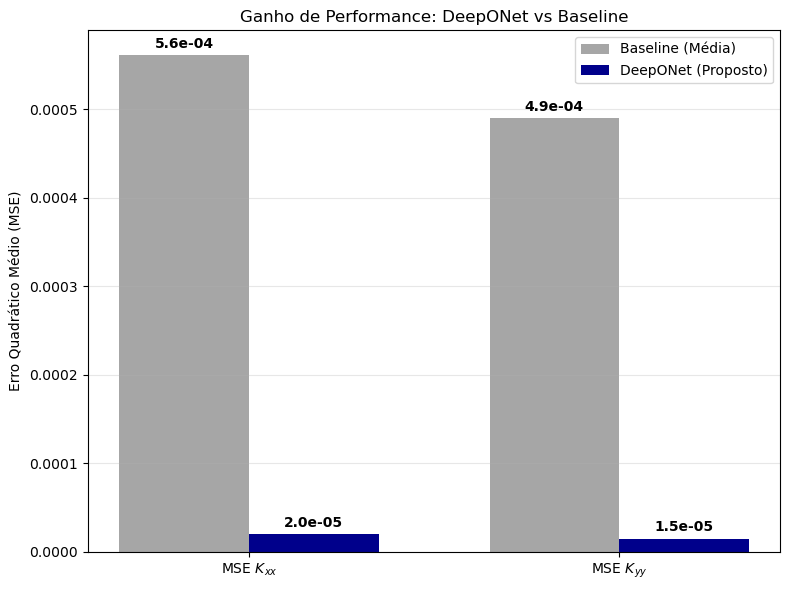

In [145]:
import matplotlib.pyplot as plt
import numpy as np
import os

# ==============================================================================
# Gráfico Comparativo: DeepONet vs Baseline
# ==============================================================================
# Objetivo: visualização do ganho de performance do modelo DeepONet em relação
# ao baseline (predição pela média do treino) utilizando MSE das propriedades
# efetivas K_xx_eff e K_yy_eff. Essa representação permite avaliação rápida
# do desempenho relativo do modelo em unidades compreensíveis.
# ==============================================================================

# Dados para plotagem
metrics_names = ['MSE $K_{xx}$', 'MSE $K_{yy}$']
model_metrics = [mse_xx, mse_yy]           # MSE do DeepONet
baseline_metrics = [mse_xx_bl, mse_yy_bl] # MSE do baseline

x = np.arange(len(metrics_names))
width = 0.35  # Largura das barras

fig, ax = plt.subplots(figsize=(8, 6))

# Criação das barras para baseline e DeepONet
rects1 = ax.bar(x - width/2, baseline_metrics, width, label='Baseline (Média)', color='gray', alpha=0.7)
rects2 = ax.bar(x + width/2, model_metrics, width, label='DeepONet (Proposto)', color='darkblue')

# Configuração de eixos e título
ax.set_ylabel('Erro Quadrático Médio (MSE)')
ax.set_title('Ganho de Performance: DeepONet vs Baseline')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Função auxiliar para adicionar valores numéricos sobre as barras
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1e}',  # Notação científica simplificada
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()

# ==============================================================================
# SALVAR FIGURA
# ==============================================================================

# Garante que a pasta de saída exista
if 'PASTA_DADOS' not in globals():
    PASTA_DADOS = "."  # Pasta atual como padrão

caminho_arquivo = os.path.join(PASTA_PLOTS, "comparacao_performance_baseline.png")

plt.savefig(
    caminho_arquivo, 
    dpi=300,               # Alta resolução adequada para publicações
    bbox_inches='tight'    # Minimiza margens em branco
)

print(f"✓ Gráfico comparativo salvo em: {caminho_arquivo}")

# Exibir gráfico
plt.show()


# Visualização comparativa:
 valores reais vs preditos para 3 amostras do conjunto de teste


Amostras de teste selecionadas (índices no conjunto de teste): [663 700 200]
Amostra 663: K_xx real=0.51826 | pred=0.52155 || K_yy real=0.52295 | pred=0.52085 | MAE médio=0.00269
Amostra 700: K_xx real=0.53735 | pred=0.53619 || K_yy real=0.51300 | pred=0.50151 | MAE médio=0.00632
Amostra 200: K_xx real=0.49482 | pred=0.49594 || K_yy real=0.50887 | pred=0.50454 | MAE médio=0.00273


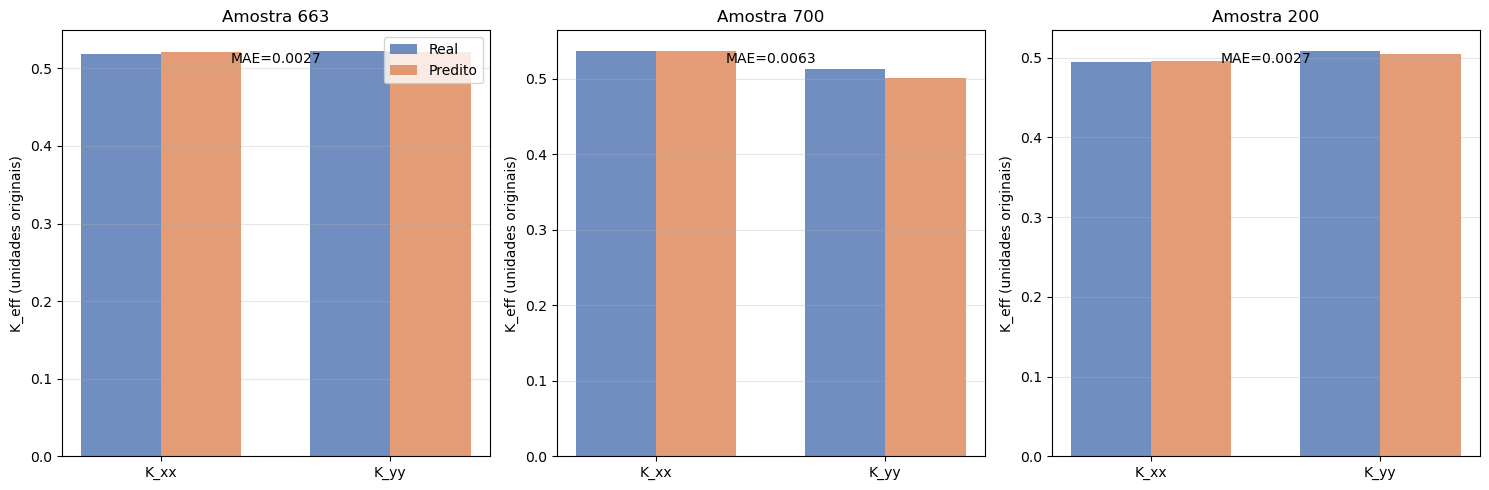

3 amostras plotadas: valores reais vs preditos em K_xx e K_yy


In [146]:
# -----------------------------------------------------------------------------
# Visualização comparativa: valores reais vs preditos para 3 amostras do conjunto de teste
# -----------------------------------------------------------------------------
# Objetivo: avaliar individualmente o desempenho do modelo DeepONet em amostras
# representativas, mostrando K_xx_eff e K_yy_eff reais versus preditos.
# Inclui cálculo do erro absoluto médio (MAE) por amostra.
# -----------------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt

# Garantir que as predições e valores reais existam
assert 'pred_test_orig' in globals(), "Execute a célula de métricas antes."
assert 'target_test_orig' in globals(), "Execute a célula de métricas antes."

# Selecionar 3 amostras aleatórias do conjunto de teste
num_samples = min(3, target_test_orig.shape[0])
indices = np.random.choice(target_test_orig.shape[0], size=num_samples, replace=False)

print("Amostras de teste selecionadas (índices no conjunto de teste):", indices)

# Impressão detalhada de valores reais, preditos e MAE por amostra
for idx in indices:
    kx_r, ky_r = target_test_orig[idx]
    kx_p, ky_p = pred_test_orig[idx]
    mae_sample = np.mean(np.abs([kx_r - kx_p, ky_r - ky_p]))
    print(f"Amostra {idx:>3}: K_xx real={kx_r:.5f} | pred={kx_p:.5f} || "
          f"K_yy real={ky_r:.5f} | pred={ky_p:.5f} | MAE médio={mae_sample:.5f}")

# -----------------------------------------------------------------------------
# Plotagem das amostras: barras comparando valores reais e preditos
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(1, num_samples, figsize=(5*num_samples, 5), squeeze=False)
axes = axes.ravel()
cats = ['K_xx', 'K_yy']
x = np.arange(len(cats))
width = 0.35

for ax, idx in zip(axes, indices):
    real_vals = target_test_orig[idx]
    pred_vals = pred_test_orig[idx]
    ax.bar(x - width/2, real_vals, width, label='Real', color='#4c72b0', alpha=0.8)
    ax.bar(x + width/2, pred_vals, width, label='Predito', color='#dd8452', alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(cats)
    ax.set_title(f"Amostra {idx}")
    ax.set_ylabel('K_eff (unidades originais)')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Indicar MAE médio da amostra no gráfico
    mae_sample = np.mean(np.abs(real_vals - pred_vals))
    ax.text(0.5, ax.get_ylim()[1]*0.95, f"MAE={mae_sample:.4f}", 
            ha='center', va='top', fontsize=10)

# Legenda apenas no primeiro subplot
axes[0].legend()
plt.tight_layout()
plt.show()

print("3 amostras plotadas: valores reais vs preditos em K_xx e K_yy")


# Pipeline de produção: carregar novos dados e prever K_eff
## Gerados de forma totalmente independente dos conjuntos de dados
## usado no Pipeline do modelo

In [171]:
import torch

# Caminho do arquivo do modelo salvo
modelo_arquivo = f"{PASTA_MODELO}/modelo_deeponet_permeabilidade.pth"

# Inicializa novamente a arquitetura (mesmos parâmetros usados no treino)
modelo_carregado = DeepONet(branch_input_dim=branch_input_dim,
                            trunk_input_dim=trunk_input_dim,
                            hidden_dim=hidden_dim)

# Carrega os pesos salvos
modelo_carregado.load_state_dict(torch.load(modelo_arquivo, map_location='cpu'))  # ou 'cuda' se GPU disponível
modelo_carregado.eval()  # Coloca em modo avaliação (desativa dropout/batchnorm)


DeepONet(
  (branch_net): BranchNet(
    (net): Sequential(
      (0): Linear(in_features=1600, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
      (6): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (trunk_net): TrunkNet(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
      (6): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (head): Linear(in_features=128, out_features=2, bias=True)
)

In [165]:

import torch

# Caminho do arquivo do modelo salvo
modelo_arquivo = f"{PASTA_MODELO}/modelo_deeponet_permeabilidade.pth"

# Inicializa novamente a arquitetura (mesmos parâmetros usados no treino)
modelo_carregado = DeepONet(branch_input_dim=branch_input_dim,
                            trunk_input_dim=trunk_input_dim,
                            hidden_dim=hidden_dim)

# Carrega os pesos salvos
modelo_carregado.load_state_dict(torch.load(modelo_arquivo, map_location='cpu'))  # ou 'cuda' se GPU disponível
modelo_carregado.eval()  # Coloca em modo avaliação (desativa dropout/batchnorm)

# -----------------------------------------------------------------------------
# Pipeline de produção (manual) para previsão de K_eff em novos dados
# -----------------------------------------------------------------------------
# Objetivo: aplicar o modelo DeepONet treinado para gerar previsões de propriedades
# efetivas (K_xx_eff e K_yy_eff) em novos campos de permeabilidade, garantindo
# consistência de normalização e uso correto das coordenadas do trunk.
# -----------------------------------------------------------------------------

NOVO_ARQ = "/home/dairsonalbert/projeto_final_FEM_Mecanica/projeto-fem-mec-continuo/dataset_deeponet/data_independente/dataset_homogeneizacao.npz"

# -----------------------------------------------------------------------------
# Verificações de consistência
# -----------------------------------------------------------------------------
assert 'model' in globals(), "Treine ou carregue o modelo antes."
assert 'escalador_ramo' in globals() and 'escalador_alvo' in globals(), "Escaladores não encontrados. Execute a normalização."
assert 'trunk_data' in globals(), "trunk_data ausente. Recrie a normalização se necessário."

# -----------------------------------------------------------------------------
# 1) Carregar novos dados
# -----------------------------------------------------------------------------
dados_novos = np.load(NOVO_ARQ)
branch_new = torch.tensor(dados_novos['branch'], dtype=torch.float32)  # shape: (N, 2, n_sensores)
target_new = torch.tensor(dados_novos['target'], dtype=torch.float32)  # shape: (N, 2), opcional

# -----------------------------------------------------------------------------
# 2) Normalizar branch usando os parâmetros do treinamento
# -----------------------------------------------------------------------------
branch_new_2d = branch_new.reshape(branch_new.shape[0], -1).numpy()   # achatamento para 2D
branch_new_norm = escalador_ramo.transform(branch_new_2d)              # aplicar StandardScaler do treino
branch_new_norm = torch.tensor(branch_new_norm, dtype=torch.float32).reshape(branch_new.shape)

# -----------------------------------------------------------------------------
# 3) Enviar dados para o mesmo device do modelo (CPU ou GPU)
# -----------------------------------------------------------------------------
branch_new_d = branch_new_norm.to(modelo_carregado.head.weight.device)
trunk_d_local = trunk_data.to(modelo_carregado.head.weight.device)  # trunk compartilhado

# -----------------------------------------------------------------------------
# 4) Predição com DeepONet e retorno ao espaço físico original
# -----------------------------------------------------------------------------
with torch.no_grad():
    preds_norm = model(branch_new_d, trunk_d_local)                 # predições normalizadas
preds_orig = escalador_alvo.inverse_transform(preds_norm.cpu().numpy())  # desnormalização

# -----------------------------------------------------------------------------
# 5) Avaliação do erro se houver valores reais
# -----------------------------------------------------------------------------
if target_new is not None:
    target_orig = target_new.cpu().numpy()
    mae = np.mean(np.abs(preds_orig - target_orig), axis=0)
    print(f"MAE K_xx={mae[0]:.6f} | MAE K_yy={mae[1]:.6f} (novos dados)")

# -----------------------------------------------------------------------------
# 6) Visualização rápida das primeiras amostras (até 20 amostras)
# -----------------------------------------------------------------------------
max_samples = 20
k = min(max_samples, preds_orig.shape[0])
for i in range(k):
    if target_new is not None:
        print(f"Amostra {i}: real=({target_orig[i,0]:.5f}, {target_orig[i,1]:.5f}) | "
              f"pred=({preds_orig[i,0]:.5f}, {preds_orig[i,1]:.5f})")
    else:
        print(f"Amostra {i}: pred=({preds_orig[i,0]:.5f}, {preds_orig[i,1]:.5f})")

# -----------------------------------------------------------------------------
# Resultado final: array com predições desnormalizadas
# -----------------------------------------------------------------------------
predicoes_novas = preds_orig
print("✓ Pipeline de previsão executado com sucesso (modo manual).")


MAE K_xx=0.003085 | MAE K_yy=0.002904 (novos dados)
Amostra 0: real=(0.50709, 0.50515) | pred=(0.50490, 0.50825)
Amostra 1: real=(0.54491, 0.54712) | pred=(0.54707, 0.54711)
Amostra 2: real=(0.46864, 0.53409) | pred=(0.47719, 0.53198)
Amostra 3: real=(0.54178, 0.52892) | pred=(0.54201, 0.53108)
Amostra 4: real=(0.48923, 0.53306) | pred=(0.48879, 0.53288)
Amostra 5: real=(0.52612, 0.51084) | pred=(0.52579, 0.50235)
Amostra 6: real=(0.49689, 0.52933) | pred=(0.50308, 0.52902)
Amostra 7: real=(0.53627, 0.47983) | pred=(0.53321, 0.48410)
Amostra 8: real=(0.51688, 0.54025) | pred=(0.52335, 0.54023)
Amostra 9: real=(0.54698, 0.53818) | pred=(0.54724, 0.53405)
Amostra 10: real=(0.43630, 0.54225) | pred=(0.40443, 0.53989)
Amostra 11: real=(0.49970, 0.52946) | pred=(0.49516, 0.53098)
Amostra 12: real=(0.53577, 0.50265) | pred=(0.53584, 0.50468)
Amostra 13: real=(0.52209, 0.53568) | pred=(0.52529, 0.53717)
Amostra 14: real=(0.52827, 0.49696) | pred=(0.52828, 0.49546)
Amostra 15: real=(0.54549, 0

(10000, 1600)

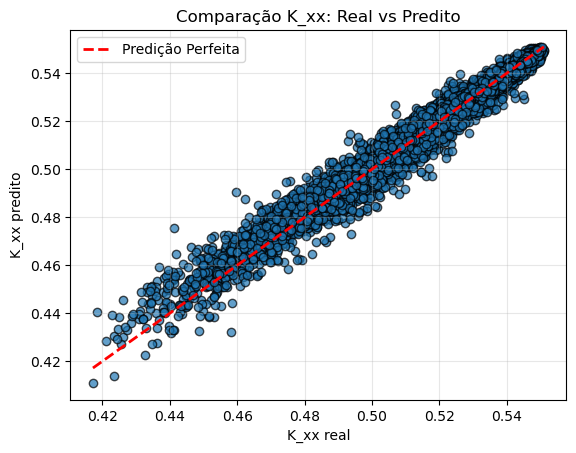

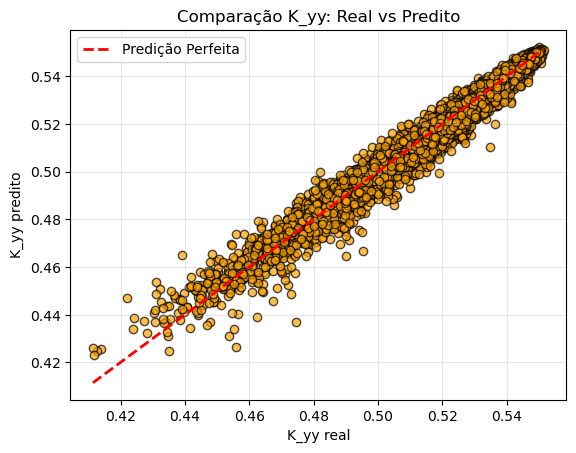

In [157]:
import matplotlib.pyplot as plt

# ==============================================================================
# Comparação Valores Reais vs Preditos para K_xx e K_yy
# ==============================================================================
# target_orig: valores reais (N, 2)
# preds_orig: valores preditos (N, 2)
# Objetivo: avaliar visualmente a precisão do modelo DeepONet no espaço físico original.

# ---------------------- K_xx ----------------------
plt.figure()
plt.scatter(target_orig[:,0], preds_orig[:,0], alpha=0.7, edgecolors='k')
# Linha de referência de predição perfeita (y = x)
plt.plot([target_orig[:,0].min(), target_orig[:,0].max()],
         [target_orig[:,0].min(), target_orig[:,0].max()],
         'r--', linewidth=2, label='Predição Perfeita')
plt.xlabel("K_xx real")
plt.ylabel("K_xx predito")
plt.title("Comparação K_xx: Real vs Predito")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ---------------------- K_yy ----------------------
plt.figure()
plt.scatter(target_orig[:,1], preds_orig[:,1], alpha=0.7, color='orange', edgecolors='k')
# Linha de referência de predição perfeita (y = x)
plt.plot([target_orig[:,1].min(), target_orig[:,1].max()],
         [target_orig[:,1].min(), target_orig[:,1].max()],
         'r--', linewidth=2, label='Predição Perfeita')
plt.xlabel("K_yy real")
plt.ylabel("K_yy predito")
plt.title("Comparação K_yy: Real vs Predito")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
